In [2]:
using NPZ
using Plots
using PaddedViews
using ProgressMeter
using LinearAlgebra
using TimerOutputs
using BenchmarkTools
using Profile

# Wczytanie danych

In [3]:
train_dict = npzread("KMNIST/kmnist-train-imgs.npz")
train_labels = npzread("KMNIST/kmnist-train-labels.npz")
test_dict = npzread("KMNIST/kmnist-test-imgs.npz")
test_labels = npzread("KMNIST/kmnist-test-labels.npz");

In [4]:
const labels = ["o", "ki", "su", "tsu", "na", "ha", "ma", "ya", "re", "wo"];

In [5]:
const train_y = convert(Vector{Int64}, train_labels["arr_0"])
const test_y = convert(Vector{Int64}, test_labels["arr_0"])

train = convert(Array{Float32}, train_dict["arr_0"])/255
train = permutedims(train, (2,3,1))
const train_x = reshape(train, (28,28,1,60000))

test = convert(Array{Float32}, test_dict["arr_0"])/255
test = permutedims(test, (2,3,1))
const test_x = reshape(test, (28,28,1,10000));

println("Train images:\t", size(train_x), "\t\t labels: ", size(train_y))
println("Test images:\t", size(test_x), "\t\t labels: ", size(test_y))

Train images:	(28, 28, 1, 60000)		 labels: (60000,)
Test images:	(28, 28, 1, 10000)		 labels: (10000,)


# Graf obliczeniowy -- węzły

In [6]:
abstract type Node end
abstract type Operator <: Node end

mutable struct Variable{N} <: Node
    name::String
    output::Array{Float64, N}
    gradient::Array{Float64, N}
    v₁::Array{Float64, N}
    v₂::Array{Float64, N}
    v̂₁::Array{Float64, N}
    v̂₂::Array{Float64, N}
    Variable(N, output; name = "?") = new{N}(name, output, zeros(size(output)), zeros(size(output)), zeros(size(output)), zeros(size(output)), zeros(size(output)))
end

mutable struct NodeOperator{F, N} <: Operator
    name::String
    inputs::Vector{Node}
    output::Array{Float64, N}
    gradient::Array{Float64, N}
    NodeOperator(fun, inputs...; name = "?", shape=(1,1,1)) = new{typeof(fun), length(shape)}(name, [inputs...], zeros(shape), zeros(shape))
end

In [7]:
import Base: show, summary
show(io::IO, x::NodeOperator{F}) where {F} = print(io, "op ", "(", F, ")");
show(io::IO, x::Variable) = begin
    print(io, "var ", x.name);
    print(io, "\n ┣━ ^ "); summary(io, x.output)
    print(io, "\n ┗━ ∇ ");  summary(io, x.gradient)
end

show (generic function with 403 methods)

# Graf obliczeniowy -- funkcje

### Tworzenie grafu

In [8]:
function visit(node::Node, visited::Set, order::Vector)
    if node ∉ visited
        push!(visited, node)
        push!(order, node)
    end
end

function visit(node::Operator, visited::Set, order::Vector)
    if node ∉ visited
        for input in node.inputs
            visit(input, visited, order)
        end
        push!(visited, node)
        push!(order, node)
    end
end


function create_graph(root::Node)
    visited = Set()
    order = Vector()
    visit(root, visited, order)
    return order
end

create_graph (generic function with 1 method)

### Przejście w przód z zerowaniem gradientu

In [9]:
zero_gradient!(node::Node) = fill!(node.gradient, 0)

compute!(node::Variable) = nothing
compute!(node::Operator) = node.output .= forward(node, [input.output for input in node.inputs]...)

function forward!(order::Vector{Node})::Float64
    for node in order
        compute!(node)
        zero_gradient!(node)
    end
    
    return last(order).output[1]
end    

forward! (generic function with 1 method)

### Przejście w tył

In [10]:
update!(node::Node, gradient) = if isempty(node.gradient)
    node.gradient = gradient else node.gradient .+= gradient
end

function backward!(order::Vector; seed = 1.0)
    result = last(order)
    result.gradient = [seed]
    
    for node in reverse(order)
        backward!(node)
    end
end

backward!(node::Variable) = nothing

function backward!(node::Operator)
    gradients = backward(node, [input.output for input in node.inputs]..., node.gradient)
    for (input, gradient) in zip(node.inputs, gradients)
        update!(input, gradient)
    end
end

backward! (generic function with 3 methods)

# Sieć i warstwy

### Definicja struktur parametrów

In [11]:
struct ConvParams
    kernels::Variable{2}
    bias::Variable{2}
end

struct DenseParams
    weights::Variable{2}
    bias::Variable{1}
end

struct CNNParams
    conv1::ConvParams
    conv2::ConvParams
    dense1::DenseParams
    dense2::DenseParams
end

### Warstwa konwolucyjna

In [74]:
conv_layer(x::Node, k::Node, b::Node, shape) = NodeOperator(conv_layer, name="conv", shape=shape, x, k, b)

forward(::NodeOperator{typeof(conv_layer)}, x, k, b) = let
    x_size = size(x)
    k_size = size(k)
    no_k = floor(Int, sqrt(k_size[2])) - 1
    x̂_size = x_size[1] - 4
    x_vectorized = zeros(k_size[2], x̂_size^2, x_size[3])
    no_patch = 1
    for c in 1:x̂_size
        for r in 1:x̂_size
            @inbounds x_vectorized[:, no_patch, :] = reshape(x[r:(r+no_k), c:(c+no_k), :], (k_size[2], 1, x_size[3]))
            no_patch += 1
        end
    end
    x̂_vectorized = zeros(k_size[1], x̂_size^2)

    @simd for i in 1:x_size[3]
        @inbounds @views x̂_vectorized[:, :] .+= k * x_vectorized[:, :, i]
    end
    
    x̂_vectorized .+= b

    x̂ = zeros(x̂_size, x̂_size, k_size[1])
    for i in 1:k_size[1]
        @inbounds x̂[:, :, i] = reshape(x̂_vectorized[i, :], (x̂_size, x̂_size))
    end
    
    return x̂
end

backward(::NodeOperator{typeof(conv_layer)}, x, k, b, g) = let
    x_size = size(x)
    k_size = size(k)
    no_k = floor(Int, sqrt(k_size[2])) - 1
    x̂_size = x_size[1] - 4
    x_vectorized = zeros(k_size[2], x̂_size^2, x_size[3])
    no_patch = 1
    for c in 1:x̂_size
        for r in 1:x̂_size
            @inbounds x_vectorized[:,no_patch, :] = reshape(x[r:(r+no_k), c:(c+no_k), :], (k_size[2], 1, x_size[3]))
            no_patch += 1
        end
    end
    
    g_vectorized = reshape(g, size(g)[1]^2, size(g)[3])
    
    dk = g_vectorized' * sum(x_vectorized, dims=3)[:,:,1]'
    
    db = sum(g_vectorized', dims=1)
    
    g_size = size(g)
    g_padded = PaddedView(0, g, (1:(g_size[1]+8), 1:(g_size[1]+8), 1:g_size[3]), (5:(g_size[1]+4), 5:(g_size[1]+4), 1:g_size[3]))
    g_pad_vect = zeros(k_size[2], (g_size[1]+4)^2, g_size[3])
    no_patch = 1
    for c in 1:(g_size[1]+4)
        for r in 1:(g_size[1]+4)
            @inbounds g_pad_vect[:, no_patch, :] = reshape(g_padded[r:(r+no_k), c:(c+no_k), :], (k_size[2], 1, g_size[3]))
            no_patch += 1
        end
    end
    k_reversed = reverse(k, dims=2)
    
    dx = zeros(g_size[3], (g_size[1]+4)^2)

    @simd for i in 1:g_size[3]
        @inbounds @views dx .+= k_reversed * g_pad_vect[:, :, i]
    end
    
    dx = sum(dx, dims=1)

    dx = repeat(reshape(dx, (x_size[1], x_size[1])), 1, 1, x_size[3])
    
    return tuple(dx, dk, db)
end

backward (generic function with 7 methods)

### Warstwa maxpool

In [57]:
maxpool_layer(x::Node, shape) = NodeOperator(maxpool_layer, name="maxpool", shape=shape, x)

forward(::NodeOperator{typeof(maxpool_layer)}, x) = let
    n = floor(Int, size(x)[1]/2) # new size
    x̂ = zeros(n, n, size(x)[3])
    s = 2 # stride
    
    @simd for r in 1:n
        for c in 1:n
            @inbounds @views x̂[r, c, :] = maximum(x[(r*s-1):(r*s), (c*s-1):(c*s), :], dims=(1,2), init=-1.0)
        end
    end
    
    return x̂
end

backward(::NodeOperator{typeof(maxpool_layer)}, x, g) = let
    n = floor(Int, size(x)[1]/2) # new size
    s = 2 # stride
    x̂ = zeros(size(x))
    
    @simd for r in 1:n
        for c in 1:n
            @inbounds @views idx = argmax(x[(r*s-1):(r*s), (c*s-1):(c*s), :], dims=(1,2))
            @inbounds @views x̂[(r*s-1):(r*s), (c*s-1):(c*s), :][idx] = g[r, c, :]
        end
    end
    return tuple(x̂)
end

backward (generic function with 7 methods)

### Warstwa flatten

In [58]:
flatten(x::Node, shape) = NodeOperator(flatten, name="flatten", shape=shape, x)

forward(::NodeOperator{typeof(flatten)}, x) = let
    return reshape(x, size(x)[1]*size(x)[2]*size(x)[3])
end

backward(::NodeOperator{typeof(flatten)}, x, g) = let
    return tuple(reshape(g, size(x)))
end

backward (generic function with 7 methods)

### Warstwa gęsta

In [59]:
dense_layer(x::Node, w::Node, b::Node, shape) = NodeOperator(dense_layer, name="dense", shape=shape, x, w, b)

forward(::NodeOperator{typeof(dense_layer)}, x, w, b) = let
    return w * x + b
end

backward(::NodeOperator{typeof(dense_layer)}, x, w, b, g) = let
    return tuple(w' * g, g * x', g)
end

backward (generic function with 7 methods)

### ReLU

In [60]:
relu(x::Node, shape) = NodeOperator(relu, name="relu", shape=shape, x)

forward(::NodeOperator{typeof(relu)}, x) = let
    return max.(x, 0)
end

backward(::NodeOperator{typeof(relu)}, x, g) = let
    id_max = findall(a -> a > 0, x)
    x̂ = zeros(Float64, size(x))
    x̂[id_max] = g[id_max]
    return tuple(x̂)
end

backward (generic function with 7 methods)

### Softmax

In [61]:
softmax(x::Node, shape) = NodeOperator(softmax, name="softmax", shape=shape, x)

forward(::NodeOperator{typeof(softmax)}, x) = let
    return exp.(x) ./ sum(exp.(x))
end

backward(node::NodeOperator{typeof(softmax)}, x, g) = let
    y = node.output
    J = diagm(y) .- y * y'
    tuple(J' * g)
end

backward (generic function with 7 methods)

### Funkcja straty -- cross entropy loss

In [62]:
cross_entropy_loss(ŷ::Node, y::Node, shape) = NodeOperator(cross_entropy_loss, name="cross_entropy_loss", shape=shape,  ŷ, y)

forward(::NodeOperator{typeof(cross_entropy_loss)}, ŷ, y) = let
    return [-log(ŷ[floor(Int, y[1]+1)])]
end

backward(::NodeOperator{typeof(cross_entropy_loss)}, ŷ, y, g) = let
    x = zeros(10)
    id = floor(Int, y[1]) + 1
    x[id] = -1 / ŷ[id] * g[1]
    return tuple(x, [0.0])
end

backward (generic function with 7 methods)

## Struktura sieci

In [50]:
function my_cnn(x::Variable{3}, y::Variable{1}, params::CNNParams)
    x₁ = conv_layer(x, params.conv1.kernels, params.conv1.bias, (24,24,20))
    x₂ = relu(x₁, (24,24,20))
    x₃ = maxpool_layer(x₂, (12,12,20))
    x₄ = conv_layer(x₃, params.conv2.kernels, params.conv2.bias, (8,8,50))
    x₅ = relu(x₄, (8,8,50))
    x₆ = maxpool_layer(x₅, (4,4,50))
    
    x₇ = flatten(x₆, (800))
    
    x₈ = dense_layer(x₇, params.dense1.weights, params.dense1.bias, (500))
    x₉ = dense_layer(x₈, params.dense2.weights, params.dense2.bias, (10))
    
    ŷ = softmax(x₉, (10))
    
    loss = cross_entropy_loss(ŷ, y, (1))
    
    return create_graph(loss)
end

my_cnn (generic function with 1 method)

### Inicjalizacja wag

In [51]:
function he_weights_init(prev, shape...)
    std = sqrt(2.0/prev)
    weights = rand(Float64, shape) .*2 .-1
    return weights .* std
end

he_weights_init (generic function with 1 method)

### Optymalizator -- ADAM

In [30]:
mutable struct Adam
    α::Float64
    ε::Float64
    m₁::Float64
    m₂::Float64
    k::Int64
    Adam(α=0.001, m₁=0.9, m₂=0.999, ε=1e-8) = new(α, ε, m₁, m₂, 1)
end

In [31]:
function update_weights!(graph, M::Adam)
    for node in graph
        if typeof(node) == Variable{1} || typeof(node) == Variable{2} || typeof(node) == Variable{3}
            update_weights_N!(node, M)
        end
    end
    M.k += 1
end



function update_weights_N!(node::Variable{T}, M::Adam) where T
    g = node.gradient
    v₁ = node.v₁
    v₂ = node.v₂
    v̂₁ = node.v̂₁
    v̂₂ = node.v̂₂
    m₁, m₂, k, α, ε = M.m₁, M.m₂, M.k, M.α, M.ε
    v₁ .= @. m₁ * v₁ + (1.0 - m₁) * g
    v₂ .= @. m₂ * v₂ + (1.0 - m₂) * (g .* g)

    v̂₁ .= v₁ ./ (1.0 - m₁^k)
    v̂₂ .= v₂ ./ (1.0 - m₂^k)

    node.output .-= @. α*v̂₁ / (sqrt(v̂₂) + ε)
    
    nothing
end

update_weights_N! (generic function with 1 method)

### Inicjalizacja parametrów sieci

In [72]:
conv1 = ConvParams(
    Variable(2, he_weights_init(28*28, 20,25), name="k1"),
    Variable(2, zeros(1,24*24), name="b1")
)
conv2 = ConvParams(
    Variable(2, he_weights_init(12*12*20, 50,25), name="k2"),
    Variable(2, zeros(1,8*8), name="b2")
)
dense1 = DenseParams(
    Variable(2, he_weights_init(4*4*50, 500,800), name="w3"),
    Variable(1, zeros(500), name="b3")
)
dense2 = DenseParams(
    Variable(2, he_weights_init(500, 10,500), name="w4"),
    Variable(1, zeros(10), name="b4")
)

cnn_params = CNNParams(conv1, conv2, dense1, dense2);

In [53]:
function validate(x, y, graph, val_x, val_y, no_val, count_class, acc_class, e)::Tuple{Float64, Array{Float64, 2}}
    correct_val = 0
    correct_class = zeros(10)
    
    @inbounds @simd for i in 1:no_val
        x.output = val_x[:,:,:,i]
        y.output = [val_y[i]]
        forward!(graph)
        pred = argmax(graph[19].output)
        if pred == (val_y[i] + 1)
            correct_val += 1
            correct_class[pred] += 1
        end
    end
    
    acc_val = correct_val/no_val
    acc_class[:, e] = correct_class ./ count_class
    
    return (acc_val, acc_class)
end

validate (generic function with 1 method)

In [63]:
#to = TimerOutput()

function train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y)
    no_train = 1000
    epochs = 3

    ids = rand(1:60000, no_train)
    data_x = train_x[:,:,:,ids]
    data_y = train_y[ids]

    no_val = 100
    ids_val = rand(1:10000, no_val)
    val_x = test_x[:,:,:,ids_val]
    val_y = test_y[ids_val]


    loss::Float64 = 0.0
    pred::UInt8 = 0
    losses = zeros(epochs)
    count_class = [count(==(i), val_y) for i in 0:9]
    acc = zeros(epochs)
    acc_class::Array{Float64, 2} = zeros(10, epochs)
    acc_val::Float64 = 0
    correct_val = 0
    correct = 0 

    for e in 1:epochs
        loss = 0
        correct = 0

        for i in 1:no_train
            x.output = data_x[:,:,:,i]
            y.output = [data_y[i]]

            loss += forward!(graph)
            prob::NodeOperator{typeof(softmax), 1} = graph[19]
            pred = argmax(prob.output)
            if pred == (data_y[i] + 1)
                correct += 1
            end

            backward!(graph)

            update_weights!(graph, adam)
        end

        losses[e] = loss/no_train
        acc[e] = correct/no_train
        acc_val, acc_class = validate(x, y, graph, val_x, val_y, no_val, count_class, acc_class, e)

        println("Epoch: ", e, "\tAverage loss: ", round(losses[e], digits=3), "\tAverage acc: ", round(acc[e],digits=3), "\tAverage val acc: ", round(acc_val, digits=3))
    end

    println(round.(acc_class[:, epochs], digits=3))
    
    return graph
end

train_cnn (generic function with 1 method)

In [39]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
y::Variable{1} = Variable(1, [train_x[1]], name="y")
graph::Vector{Node} = my_cnn(x, y, cnn_params)
adam = Adam()

@btime train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y); #300

Epoch: 1	Average loss: 1.23	Average acc: 0.613	Average val acc: 0.53
Epoch: 2	Average loss: 0.808	Average acc: 0.75	Average val acc: 0.58
Epoch: 3	Average loss: 0.681	Average acc: 0.77	Average val acc: 0.53
[0.3, 0.75, 0.545, 0.571, 0.917, 0.667, 0.286, 0.5, 0.364, 0.444]
Epoch: 1	Average loss: 1.345	Average acc: 0.653	Average val acc: 0.57
Epoch: 2	Average loss: 0.932	Average acc: 0.72	Average val acc: 0.49
Epoch: 3	Average loss: 0.641	Average acc: 0.8	Average val acc: 0.51
[0.333, 0.667, 0.667, 0.444, 0.364, 0.7, 0.857, 0.5, 0.333, 0.286]
Epoch: 1	Average loss: 1.265	Average acc: 0.64	Average val acc: 0.4
Epoch: 2	Average loss: 0.926	Average acc: 0.737	Average val acc: 0.57
Epoch: 3	Average loss: 0.908	Average acc: 0.737	Average val acc: 0.58
[0.75, 0.7, 0.75, 0.545, 0.6, 0.733, 0.25, 0.385, 1.0, 0.2]
Epoch: 1	Average loss: 1.274	Average acc: 0.617	Average val acc: 0.49
Epoch: 2	Average loss: 1.058	Average acc: 0.71	Average val acc: 0.52
Epoch: 3	Average loss: 0.736	Average acc: 0.76

In [73]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
y::Variable{1} = Variable(1, [train_x[1]], name="y")
graph::Vector{Node} = my_cnn(x, y, cnn_params)
adam = Adam()

@btime train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y); #1000

Epoch: 1	Average loss: 1.455	Average acc: 0.535	Average val acc: 0.48
Epoch: 2	Average loss: 1.064	Average acc: 0.671	Average val acc: 0.49
Epoch: 3	Average loss: 0.999	Average acc: 0.664	Average val acc: 0.45
[0.4, 0.444, 0.308, 0.1, 0.444, 0.625, 0.583, 0.3, 0.727, 0.625]
Epoch: 1	Average loss: 1.194	Average acc: 0.632	Average val acc: 0.51
Epoch: 2	Average loss: 1.048	Average acc: 0.668	Average val acc: 0.53
Epoch: 3	Average loss: 0.99	Average acc: 0.679	Average val acc: 0.57
[0.6, 0.545, 0.833, 0.727, 0.556, 0.417, 0.6, 0.429, 0.6, 0.25]
Epoch: 1	Average loss: 1.192	Average acc: 0.638	Average val acc: 0.64
Epoch: 2	Average loss: 1.009	Average acc: 0.679	Average val acc: 0.58
Epoch: 3	Average loss: 1.023	Average acc: 0.666	Average val acc: 0.58
[0.625, 0.875, 0.556, 0.9, 0.583, 0.2, 0.5, 0.5, 0.25, 0.583]
Epoch: 1	Average loss: 1.097	Average acc: 0.667	Average val acc: 0.47
Epoch: 2	Average loss: 0.999	Average acc: 0.692	Average val acc: 0.44
Epoch: 3	Average loss: 1.107	Average acc

In [55]:
x::Variable{3} = Variable(3, train_x[:,:,:,1], name="x")
y::Variable{1} = Variable(1, [train_x[1]], name="y")
graph::Vector{Node} = my_cnn(x, y, cnn_params)
adam = Adam()

train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y); #1000
show(to)
reset_timer!(to)

Epoch: 1	Average loss: 1.419	Average acc: 0.531	Average val acc: 0.58
Epoch: 2	Average loss: 1.102	Average acc: 0.648	Average val acc: 0.6
Epoch: 3	Average loss: 1.124	Average acc: 0.655	Average val acc: 0.59
[0.833, 0.091, 0.625, 0.75, 0.667, 0.647, 0.7, 0.429, 0.545, 0.625]
 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            82.2s /  68.7%           62.8GiB /  99.7%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 backward               3.00k    41.0s   72.5%  13.7ms   56.3GiB   89.9%  19.2MiB
   conv backward        6.00k    31.6s   56.0%  5.27ms   45.1GiB   72.0%  7.70MiB
   dense backward       6.00k    5.14s    9.1%   857μs   9.08GiB  

 ────────────────────────────────────────────────────────────────────
                            Time                    Allocations      
                   ───────────────────────   ────────────────────────
 Tot / % measured:      463ms /   0.0%           40.7MiB /   0.0%    

 Section   ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────
 ────────────────────────────────────────────────────────────────────

In [34]:
@code_warntype  train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y)

In [75]:
 train_cnn(x, y, graph, adam, train_x, train_y, test_x, test_y)

Epoch: 1	Average loss: 1.188	Average acc: 0.627	Average val acc: 0.61
Epoch: 2	Average loss: 1.098	Average acc: 0.663	Average val acc: 0.58
Epoch: 3	Average loss: 1.044	Average acc: 0.667	Average val acc: 0.56
[0.545, 0.444, 0.462, 0.857, 0.778, 0.667, 0.538, 0.538, 0.429, 0.333]


21-element Vector{Node}:
 var x
 ┣━ ^ 28×28×1 Array{Float64, 3}
 ┗━ ∇ 28×28×1 Array{Float64, 3}
 var k1
 ┣━ ^ 20×25 Matrix{Float64}
 ┗━ ∇ 20×25 Matrix{Float64}
 var b1
 ┣━ ^ 1×576 Matrix{Float64}
 ┗━ ∇ 1×576 Matrix{Float64}
 op (typeof(conv_layer))
 op (typeof(relu))
 op (typeof(maxpool_layer))
 var k2
 ┣━ ^ 50×25 Matrix{Float64}
 ┗━ ∇ 50×25 Matrix{Float64}
 var b2
 ┣━ ^ 1×64 Matrix{Float64}
 ┗━ ∇ 1×64 Matrix{Float64}
 op (typeof(conv_layer))
 op (typeof(relu))
 op (typeof(maxpool_layer))
 op (typeof(flatten))
 var w3
 ┣━ ^ 500×800 Matrix{Float64}
 ┗━ ∇ 500×800 Matrix{Float64}
 var b3
 ┣━ ^ 500-element Vector{Float64}
 ┗━ ∇ 500-element Vector{Float64}
 op (typeof(dense_layer))
 var w4
 ┣━ ^ 10×500 Matrix{Float64}
 ┗━ ∇ 10×500 Matrix{Float64}
 var b4
 ┣━ ^ 10-element Vector{Float64}
 ┗━ ∇ 10-element Vector{Float64}
 op (typeof(dense_layer))
 op (typeof(softmax))
 var y
 ┣━ ^ 1-element Vector{Float64}
 ┗━ ∇ 1-element Vector{Float64}
 op (typeof(cross_entropy_loss))

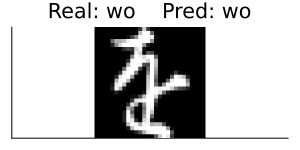

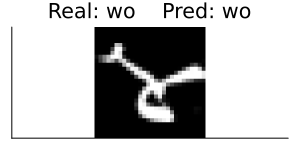

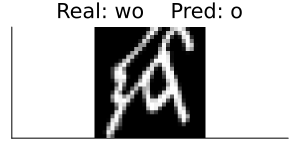

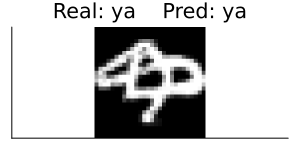

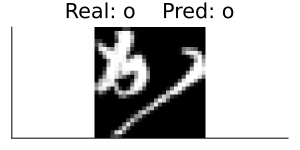

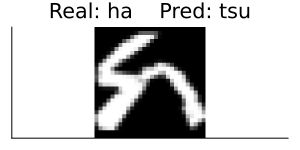

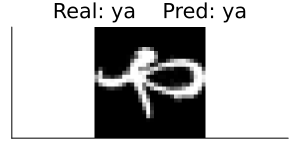

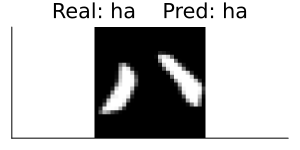

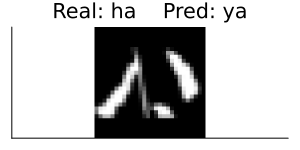

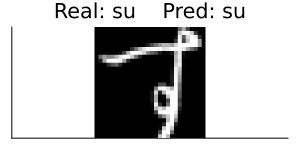

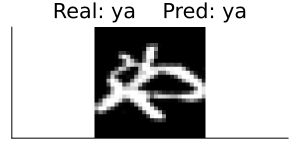

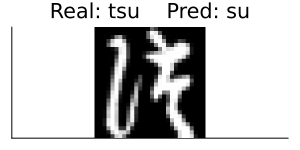

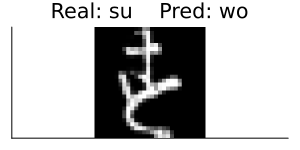

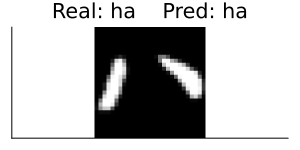

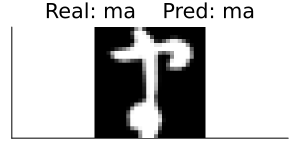

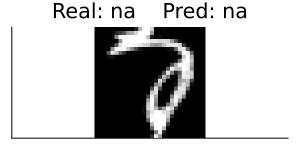

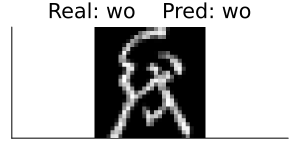

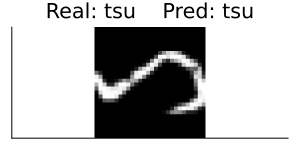

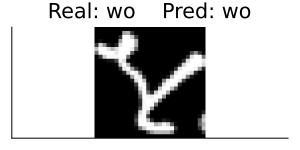

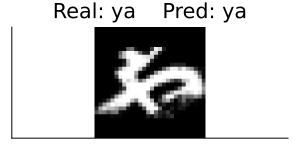

In [35]:
for i in 1:20
    id = rand(1:60000, 1)[1]
    img = train_x[:,:,:,id]
    img_label = [train_y[id]]
    x = Variable(3, img, name="x")
    y = Variable(1, img_label, name="y")
    graph = my_cnn(x, y, cnn_params)
    forward!(graph)
    real_label = labels[img_label[1]+1]
    pred = labels[argmax(graph[19].output)]
    display(plot(Gray.(img[:,:,1]), axis=nothing, size=(300,150), title="Real: $real_label    Pred: $pred"))
end